# Image Processing: Histogram of Oriented Gradients (HOG) with MNIST Dataset

In [28]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# get training and test set
mnist_train = MNIST("./data/", download = True, transform = transforms.ToTensor())
mnist_test = MNIST("./data/", train = False, download = True, transform = transforms.ToTensor())

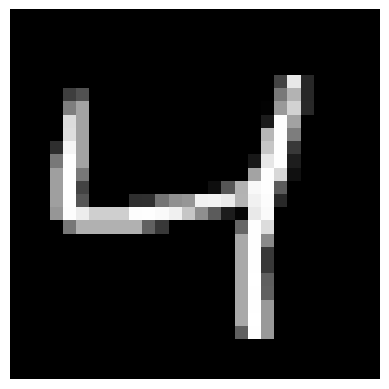

SHAPE: torch.Size([28, 28])
LABEL: tensor(4)


In [19]:
# show sample image
plt.imshow(mnist_train.data[2], cmap = "gray")
plt.axis("off")
plt.show()

print("SHAPE:", mnist_train.data[2].shape)
print("LABEL:", mnist_train.targets[2])

In [34]:
# hog for sample image
features = hog(
    mnist_train.data[2].numpy(),
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
)

In [37]:
features.shape

(144,)

In [25]:
# data loader
batch_size = 64
train_set_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True)
test_set_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = True)

In [42]:
# apply HOG on MNIST
def hog_mnist(datasetloader, resize_shape = (28, 28), orientations = 9, pixels_per_cell = (8, 8), cells_per_block = (4,4)):
    hog_features = []
    labels = []
    for images, labels in datasetloader:
        for image in images:
            image = image.numpy()
            image = resize(image, resize_shape)
            hog_feature = hog(
                image,
                orientations = orientations,
                pixels_per_cell = pixels_per_cell,
                cells_per_block = cells_per_block,
                channel_axis = -1
            )
            hog_features.append(hog_feature)
            print(hog_feature)
    return hog_features, labels

In [ ]:
# generate HOG features
hog_features, labels = hog_mnist(train_set_loader)

In [43]:
# classification with SVM loss
svm = nn.Linear(144, 10)
criterion = nn.MultiLabelMarginLoss()
optimizer = torch.optim.SGD(svm.parameters(), lr = 0.01)

num_epochs = 40
for it in range(num_epochs):
    optimizer.zero_grad()
    features, labels = hog_mnist(train_set_loader)
    print(len(features), type(features))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

KeyboardInterrupt: 